Importando bibliotecas e arquivo .csv

In [0]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


#uploaded = files.upload()


# Path of the file to read
fifa_filepath = "data.csv"
# Read the file into a variable iris_data
data = pd.read_csv(fifa_filepath)
# Print the first 5 rows of the data
#data.head()





---
Ajustando os dados do arquivo

---





In [0]:

df2 = data.loc[:, 'Crossing':'Release Clause']
df1 = data[['Age', 'Overall', 'Value', 'Wage', 'Skill Moves', 'Position', 'Height', 'Weight']] # sem o atributo "Preferred Foot"
df = pd.concat([df1, df2], axis=1)

df = df.dropna()

def value_to_int(df_value):
    try:
        value = float(df_value[1:-1])
        suffix = df_value[-1:]

        if suffix == 'M':
            value = value * 1000000
        elif suffix == 'K':
            value = value * 1000
    except ValueError:
        value = 0
    return value
  
df['Value_float'] = df['Value'].apply(value_to_int)
df['Wage_float'] = df['Wage'].apply(value_to_int)
df['Release_Clause_float'] = df['Release Clause'].apply(lambda m: value_to_int(m))

def weight_to_int(df_weight):
    value = df_weight[:-3]
    return value
  
df['Weight_int'] = df['Weight'].apply(weight_to_int)
df['Weight_int'] = df['Weight_int'].apply(lambda x: int(x))

def height_to_int(df_height):
    try:
        feet = int(df_height[0])
        dlm = df_height[-2]

        if dlm == "'":
            height = round((feet * 12 + int(df_height[-1])) * 2.54, 0)
        elif dlm != "'":
            height = round((feet * 12 + int(df_height[-2:])) * 2.54, 0)
    except ValueError:
        height = 0
    return height

df['Height_int'] = df['Height'].apply(height_to_int)


df = df.drop(['Value', 'Wage', 'Release Clause', 'Weight', 'Height'], axis=1)

le_foot = preprocessing.LabelEncoder()
#df["Preferred Foot"] = le_foot.fit_transform(df["Preferred Foot"].values)


for i in ['ST', 'CF', 'LF', 'LS', 'LW', 'RF', 'RS', 'RW']:
  df.loc[df.Position == i , 'Pos'] = 'Strikers' 

for i in ['CAM', 'CDM', 'LCM', 'CM', 'LAM', 'LDM', 'LM', 'RAM', 'RCM', 'RDM', 'RM']:
  df.loc[df.Position == i , 'Pos'] = 'Midfielder' 

for i in ['CB', 'LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB','GK']:
  df.loc[df.Position == i , 'Pos'] = 'Defender' 



---

# Data visualization


---

Distribuição geral dos dados para as classes de posições.


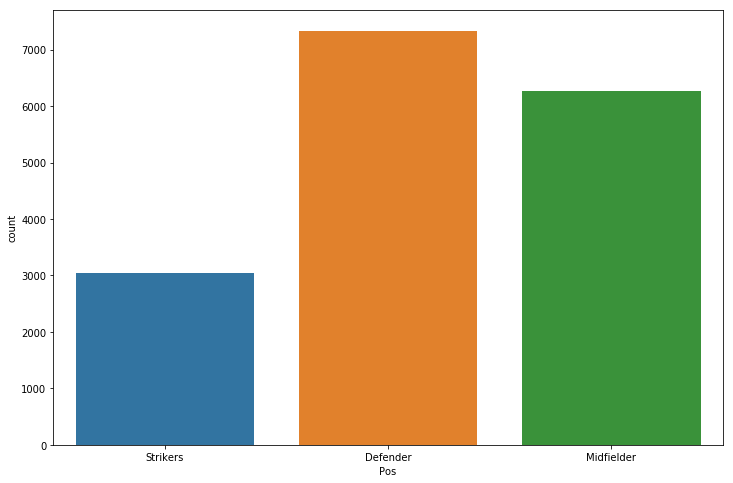

<Figure size 864x576 with 0 Axes>

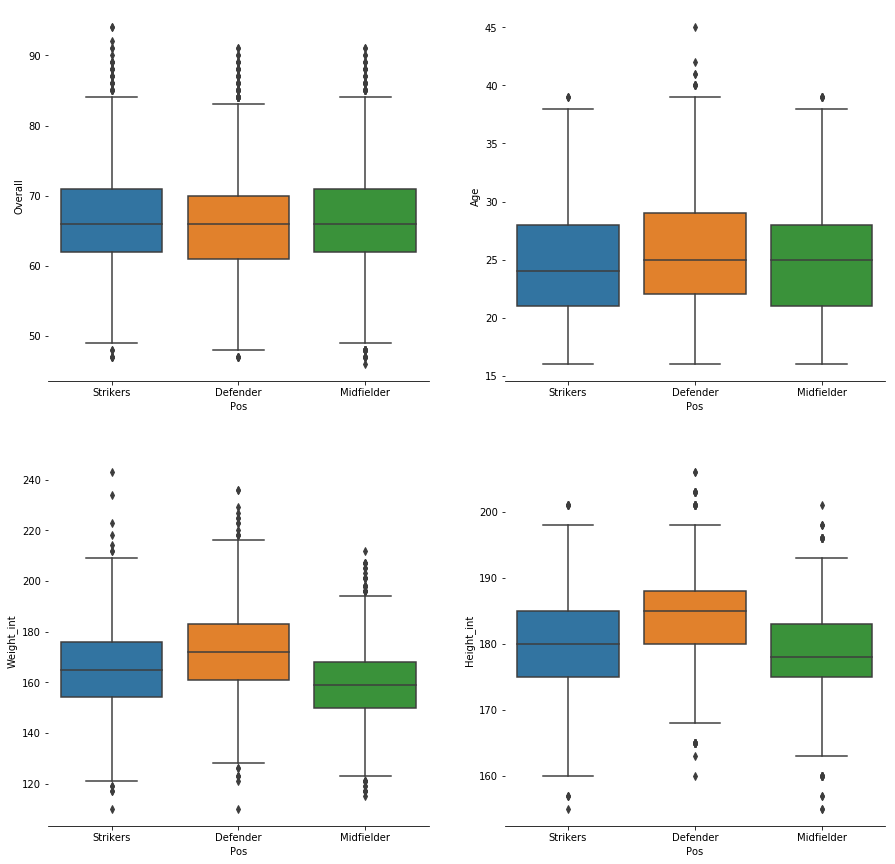

In [0]:
plt.figure(figsize=(12, 8))
fig = sns.countplot(x = 'Pos', data =df)

plt.figure(figsize=(12, 8))

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=False)
sns.despine(left=True)

sns.boxplot('Pos', 'Overall', data = df, ax=axes[0, 0])
sns.boxplot('Pos', 'Age', data = df, ax=axes[0, 1])

sns.boxplot('Pos', 'Height_int', data = df, ax=axes[1, 1])
sns.boxplot('Pos', 'Weight_int', data = df, ax=axes[1, 0])




---



Segue abaixo um plot de três gráficos contendo os seguintes atributos: Finishing (eixo X) e Interceptions (eixo Y) , os gráficos  são das classes “Striker” , “Defender” e “Midfielder” respectivamente. Podemos ver que os atributos “Finishing” e “Marking "" são atributos que conseguem separar consideravelmente bem as classes "Defender" e "Striker". É interessante notar que aquele conjunto separado de bolinhas na classe "Defender" são referente os goleiros.

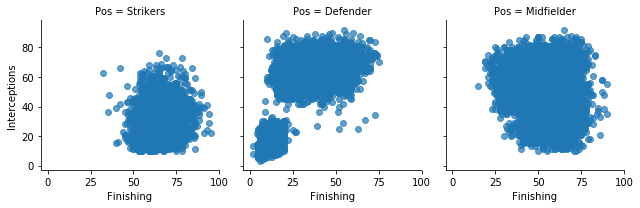

In [0]:
eixoX='Finishing'
eixoY='Interceptions'
g = sns.FacetGrid(df, col="Pos")
g.map(plt.scatter, eixoX, eixoY, alpha=.7)
#g.add_legend();
plt.show()

A seguir  temos as distribuições dos atributos "Interceptions" e "Finishing" na qual podemos observar que o atributo Interceptions possui dois momentos com grandes concentraçoes de exemplos.

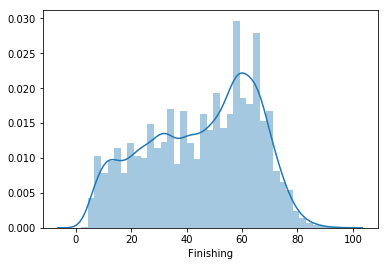

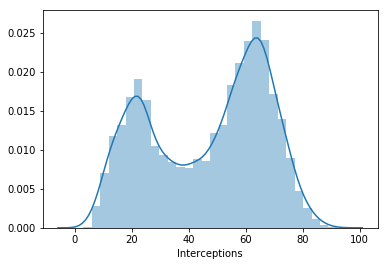

In [0]:
# Distribuicao #

sns.distplot(df[eixoX])
plt.show()
sns.distplot(df[eixoY])
plt.show()



---


Neste dataSet existem muitos atributos que são ligados uns aos outros, por exemplo, os atributos finalização e curva, ou o nível de marcação com a interceptação.
O caso abaixo demonstra a comparação entre o atributo "Curve" e "Finishing" onde a cor é o  Curve ,  o eixo X é Finishing e o Y Interceptions. 
Podemos observar que a medida em que o valor de Finishing aumenta, as cores dos elementos também vão alterando para cores que representam valores maiores do atributo Curve.


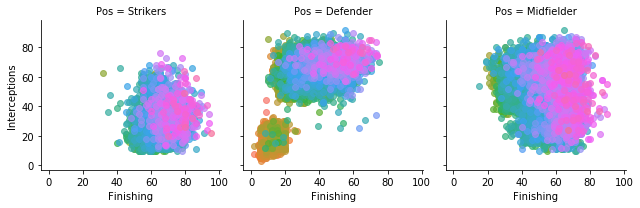

In [0]:
eixoX='Finishing'
eixoY='Interceptions'
varCor="Curve"
g = sns.FacetGrid(df, col="Pos", hue=varCor)
g.map(plt.scatter, eixoX, eixoY, alpha=.7)
#g.add_legend();
plt.show()




---


No caso abaixo temos no eixo X Finalization, no eixo Y Interceptions e as cores são o atributo "Overall".

O fator interessante da junção do atributo Overall é que ele pode ser observado como uma espécie de limitador de classes quando combinado com outros atributos, isso pois podemos observar que ele possui valor baixo (cor quente) no limite inferior e alto no limite superior (cor fria) .

Em outras palavras podemos dizer que temos atacantes bons (Overall alto) e outros ruins (Overall baixo) mas ambos são atacantes e possuem , por exemplo, uma habilidade de finalização consideravelmente mais alta que a de marcação.

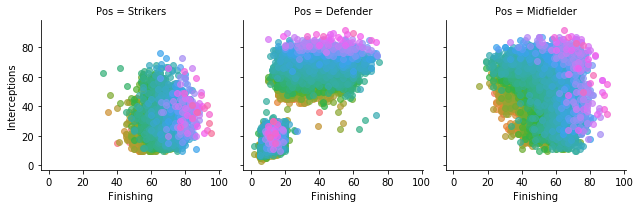

In [0]:
eixoX='Finishing'
eixoY='Interceptions'
varCor="Overall"
g = sns.FacetGrid(df, col="Pos", hue=varCor)
g.map(plt.scatter, eixoX, eixoY, alpha=.7)

plt.show()

# Treinos e predições




---

Abaixo é feita a separação de teste e treido e depois verificado em uma faixa de valores o melhor valor para utilizar o valor mínimo de impureza para separar um nó folha (isso para os dados de treino).


In [0]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
lasso = linear_model.Lasso()
from sklearn.model_selection import train_test_split
le_class = preprocessing.LabelEncoder()


df['Pos'] = le_class.fit_transform(df['Pos'])

y = df["Pos"]

df.drop(columns=["Position","Pos"],inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df, y, 
                                                    test_size=0.2,
                                                    random_state=42)

In [0]:

from sklearn import tree
from sklearn.model_selection import cross_val_score

tr_acc = []
mln_set = range(75,90)																		#Setando os valores em que iremos testar os nós folha, inicio e fim											
# min_impurity = 82/100000                                #Anterior

for minImp in mln_set:
	clf = tree.DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=minImp/100000)	#controlando o valor máximo de nós folha
	scores = cross_val_score(clf, X_train, y_train, cv=10)
	tr_acc.append(scores.mean())

best_mln = mln_set[np.argmax(tr_acc)]
print(best_mln)


77


**Árvore de decisão** simples alterando somente o critério de divisão para entropia e o mínimo de entropia em cada nó para que este seja dividido ou não.

[[1309  135    2]
 [  93 1082   95]
 [   1  146  466]]
0.8582156803844998


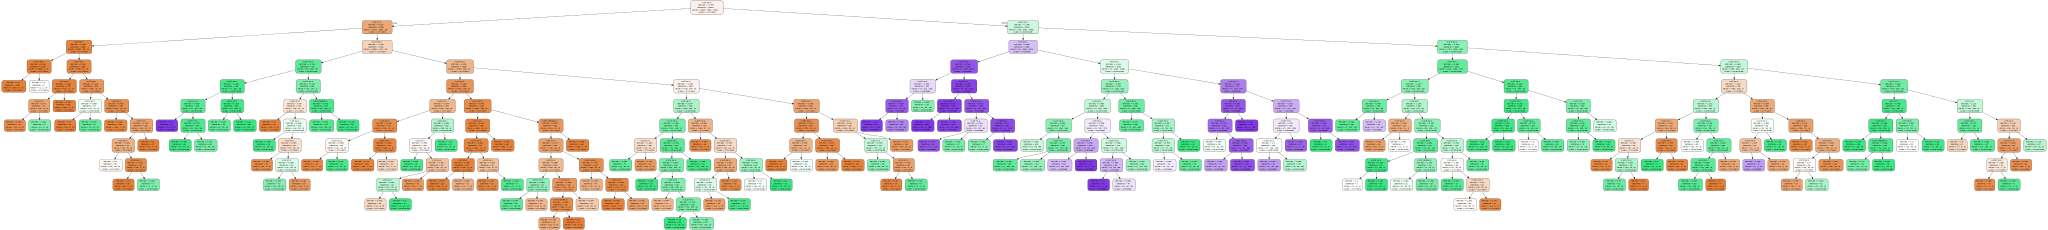

In [0]:
from sklearn import tree
import graphviz
from IPython.display import SVG
from IPython.display import display

clf = tree.DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=best_mln/100000)#
clf = clf.fit(X_train, y_train)

preds = clf.predict(X_test)												#Predict do teste
preds_train = clf.predict(X_train)

print(confusion_matrix(y_test, preds))
print(accuracy_score(y_test,preds))

#printando a árvore
dot_data = tree.export_graphviz(clf, out_file=None,filled=True, rounded=True, class_names=['Strikers','Midfielder','Defender'],special_characters=True) 
graph = graphviz.Source(dot_data) 
display(SVG(graph.pipe(format='svg')))

**Bagging**

Baggin realizado com árvores com os mesmos parâmetros da árvore mostrada anteriormente


In [0]:
from sklearn import tree
import graphviz
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=best_mln/100000))#

clf = clf.fit(X_train, y_train)
preds = clf.predict(X_test)


print(preds)

print(accuracy_score(y_test,preds))

[0 0 2 ... 1 0 1]
0.8834484830279363




---


**XGBoost**

In [0]:
dtrain = xgb.DMatrix(X_train, label=y_train)

dtest = xgb.DMatrix(X_test,label=y_test)

param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 50  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)
bst.dump_model('dump.raw.txt')
preds = bst.predict(dtest)
preds_train = bst.predict(dtrain)

best_preds = np.asarray([np.argmax(line) for line in preds])

best_preds_train = np.asarray([np.argmax(line) for line in preds_train])

cf_train = confusion_matrix(y_train, best_preds_train)

accuracy_score(y_train, best_preds_train)

cf = confusion_matrix(y_test, best_preds)

accuracy_score(y_test, best_preds)



/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.8885551216581556

In [0]:


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from datetime import datetime



In [0]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [0]:


# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.3,0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,7]
        }



xgb_class = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:logistic',
                    silent=True, nthread=1)



In [0]:
folds = 10
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_class, param_distributions=params, n_iter=param_comb, n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train,y_train)
timer(start_time) # timing ends here for "start_time" variab



Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 17.2min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 31.2min finished



 Time taken: 0 hours 32 minutes and 11.95 seconds.


In [0]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 All results:
{'mean_fit_time': array([146.48464656, 172.58295755, 206.55385888,  93.15808334,
       121.6878417 ]), 'std_fit_time': array([ 1.3194859 ,  2.02709734,  2.05736483,  1.08290996, 10.58061011]), 'mean_score_time': array([0.57819343, 0.62268529, 0.66511846, 0.31925573, 0.42494898]), 'std_score_time': array([0.0170494 , 0.01579687, 0.05096842, 0.02371246, 0.11925667]), 'param_subsample': masked_array(data=[0.6, 0.8, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[10, 10, 10, 10, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[7, 7, 7, 5, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[2, 0.5, 0.5, 5, 0.5],
             mask=[False, False, False, False, False],
       

In [0]:


param = {'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 7, 'gamma': 0.5, 'colsample_bytree': 1.0,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset

num_round = 50  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)
bst.dump_model('dump.raw.txt')
preds = bst.predict(dtest)
preds_train = bst.predict(dtrain)



In [0]:


best_preds = np.asarray([np.argmax(line) for line in preds])

best_preds_train = np.asarray([np.argmax(line) for line in preds_train])

cf_train = confusion_matrix(y_train, best_preds_train)

accuracy_score(y_train, best_preds_train)

cf = confusion_matrix(y_test, best_preds)

accuracy_score(y_test, best_preds)

0.8960648843496546